# Leer archivos csv

In [9]:
import numpy as np
import pandas as pd
df_2022 = pd.read_csv("CO_Mississippi_2022.csv")
df_2023 = pd.read_csv("CO_Mississippi_2023.csv")
df_2024 = pd.read_csv("CO_Mississippi_2024.csv")

# Concatenar dataframe

In [11]:
df = pd.concat([df_2022, df_2023, df_2024])
df.to_csv("CO_Mississippi_2022_2024.csv", index=False)
print("Archivo guardado: CO_Mississippi_2022_2024.csv")

df.head()

Archivo guardado: CO_Mississippi_2022_2024.csv


,Date,Source,Site ID,POC,Daily Max 8-hour CO Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,AQS Parameter Description,Method Code,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
0,01/01/2022,AQS,280490020,1,0.1,ppm,1,Jackson NCORE,17,71.0,...,Carbon monoxide,593,27140,"Jackson, MS",28,Mississippi,49,Hinds,32.329111,-90.182722
1,01/02/2022,AQS,280490020,1,0.2,ppm,2,Jackson NCORE,24,100.0,...,Carbon monoxide,593,27140,"Jackson, MS",28,Mississippi,49,Hinds,32.329111,-90.182722
2,01/03/2022,AQS,280490020,1,0.2,ppm,2,Jackson NCORE,24,100.0,...,Carbon monoxide,593,27140,"Jackson, MS",28,Mississippi,49,Hinds,32.329111,-90.182722
3,01/04/2022,AQS,280490020,1,0.2,ppm,2,Jackson NCORE,24,100.0,...,Carbon monoxide,593,27140,"Jackson, MS",28,Mississippi,49,Hinds,32.329111,-90.182722
4,01/05/2022,AQS,280490020,1,0.2,ppm,2,Jackson NCORE,24,100.0,...,Carbon monoxide,593,27140,"Jackson, MS",28,Mississippi,49,Hinds,32.329111,-90.182722


# Modelo 1
### CO 2025 — Forecast solo con features de fecha (sin usar 2025)
- Train: 2022-01-01 .. 2024-03-31     | Test: 2024-04-01 .. 2024-12-31
- Predicción 2025 completa y comparación con reales.

In [14]:
!pip -q install xgboost>=2.0

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error as sk_mse, mean_absolute_error as sk_mae, r2_score

# ---------- Rutas ----------
PATH_2324 = "CO_Mississippi_2022_2024.csv"
PATH_2025  = "CO_Mississipi_2025.csv"

# ---------- Columnas ----------
COL_DATE = "Date"
COL_CO   = "Daily Max 8-hour CO Concentration"
COL_AQI  = "Daily AQI Value"  # no se usa para predecir 2025, se incluye para consistencia

# ---------- Utilidades ----------
def load_file(path):
    df = pd.read_csv(path)
    df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors="coerce")
    df = df[[COL_DATE, COL_CO, COL_AQI]].dropna(subset=[COL_DATE]).sort_values(COL_DATE)
    return df.rename(columns={COL_CO:"CO", COL_AQI:"AQI"})

def to_daily(df):
    df = df.set_index("Date").asfreq("D")
    for c in df.columns:
        df[c] = df[c].interpolate(limit_direction="both")
    return df

# dummies canónicas para asegurar MISMAS columnas en train/test/2025
DOW_COLS = [f"dow_{d}" for d in range(7)]
MON_COLS = [f"m_{m}"   for m in range(1,13)]

def build_date_features(index_like):
    t = np.arange(len(index_like))
    out = pd.DataFrame(index=index_like)
    # Tendencia + estacionalidad
    out["t"] = t/365.0
    out["sin7"]   = np.sin(2*np.pi*t/7);      out["cos7"]   = np.cos(2*np.pi*t/7)
    out["sin365"] = np.sin(2*np.pi*t/365.25); out["cos365"] = np.cos(2*np.pi*t/365.25)
    # Dummies completas (todas las categorías)
    dow = pd.get_dummies(pd.Series(index_like.weekday, index=index_like), prefix="dow", dtype="int8")
    mon = pd.get_dummies(pd.Series(index_like.month,   index=index_like), prefix="m",   dtype="int8")
    for c in DOW_COLS:
        if c not in dow.columns: dow[c] = 0
    for c in MON_COLS:
        if c not in mon.columns: mon[c] = 0
    dow = dow[DOW_COLS]; mon = mon[MON_COLS]
    out = pd.concat([out, dow, mon], axis=1).astype("float32")
    # orden estable de columnas
    cols = ["t","sin7","cos7","sin365","cos365"] + DOW_COLS + MON_COLS
    return out[cols]

# ---------- Carga ----------
df_2324 = to_daily(load_file(PATH_2324))   # 2022-2024
df_2025 = to_daily(load_file(PATH_2025))   # solo para comparar al final

In [15]:
df_2324.head()

,CO,AQI
Date,,
2022-01-01,0.1,1.0
2022-01-02,0.2,2.0
2022-01-03,0.2,2.0
2022-01-04,0.2,2.0
2022-01-05,0.2,2.0


In [16]:
df_2025.head()

,CO,AQI
Date,,
2025-01-01,0.3,3.0
2025-01-02,0.6,7.0
2025-01-03,0.7,8.0
2025-01-04,0.3,3.0
2025-01-05,0.2,2.0


Validación 2024 (Abr–Dic): RMSE=0.1864 | MAE=0.1507 | R²=-0.5696
Comparación 2025 (Ene–Ago): RMSE=0.2770 | MAE=0.2261 | R²=-2.5440


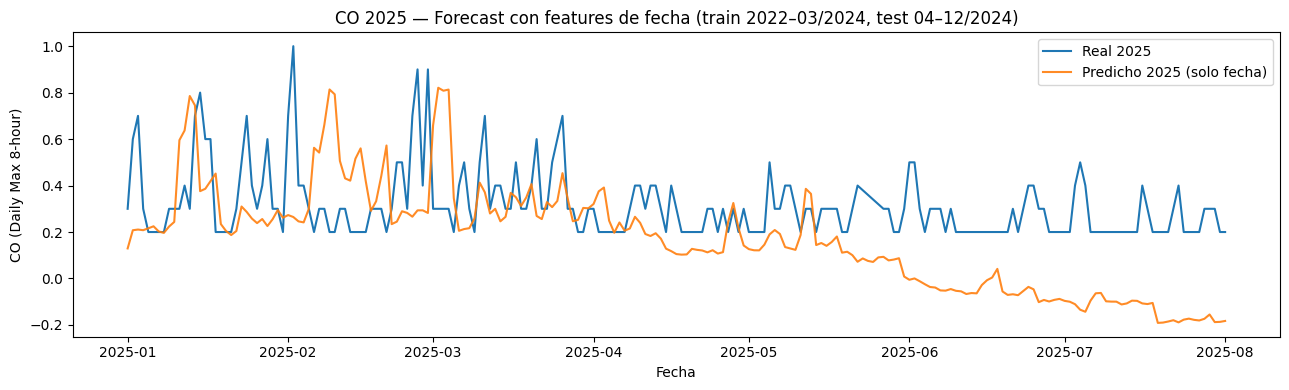

In [21]:
# ---------- Conjunto de features/target ----------
X_all = build_date_features(df_2324.index)
y_all = df_2324["CO"].astype("float32").values

# ---------- Split temporal 70/30 ----------
SPLIT_DATE = pd.Timestamp("2024-04-01")
mask_tr = X_all.index < SPLIT_DATE
mask_te = X_all.index >= SPLIT_DATE

X_train, y_train = X_all.loc[mask_tr], y_all[mask_tr]
X_test,  y_test  = X_all.loc[mask_te], y_all[mask_te]

# lista de nombres de columnas (evita el error de pandas.Index)
feature_names = list(X_train.columns)

# ---------- Modelo XGBoost ----------
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feature_names)

params = dict(
    objective="reg:squarederror",
    eval_metric="rmse",
    eta=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1.0,
    reg_lambda=0.6,
    tree_method="hist",
    random_state=42,
)

bst = xgb.train(params, dtrain, num_boost_round=3000,
                evals=[(dtest,"valid")],
                early_stopping_rounds=200, verbose_eval=False)

# ---------- Métricas de validación (Abr–Dic 2024) ----------
pred_test = bst.predict(dtest)
rmse_24 = float(np.sqrt(sk_mse(y_test, pred_test)))
mae_24  = float(sk_mae(y_test, pred_test))
r2_24   = float(r2_score(y_test, pred_test))
print(f"Validación 2024 (Abr–Dic): RMSE={rmse_24:.4f} | MAE={mae_24:.4f} | R²={r2_24:.4f}")

# ---------- Forecast 2025 (sin usar AQI 2025) ----------
X_25 = build_date_features(df_2025.index)
X_25 = X_25.reindex(columns=feature_names, fill_value=0).astype("float32")
d25  = xgb.DMatrix(X_25, feature_names=feature_names)
pred_25 = bst.predict(d25)

# ---------- Comparación con reales 2025 ----------
cmp = pd.DataFrame({
    "Date": df_2025.index,
    "CO_real": df_2025["CO"].values,
    "CO_pred": pred_25
}).dropna()

rmse_25 = float(np.sqrt(sk_mse(cmp["CO_real"], cmp["CO_pred"])))
mae_25  = float(sk_mae(cmp["CO_real"], cmp["CO_pred"]))
r2_25   = float(r2_score(cmp["CO_real"], cmp["CO_pred"]))
print(f"Comparación 2025 (Ene–Ago): RMSE={rmse_25:.4f} | MAE={mae_25:.4f} | R²={r2_25:.4f}")

# ---------- Gráfico 2025 ----------
plt.figure(figsize=(13,4))
plt.plot(cmp["Date"], cmp["CO_real"], label="Real 2025")
plt.plot(cmp["Date"], cmp["CO_pred"], label="Predicho 2025 (solo fecha)", alpha=0.9)
plt.title("CO 2025 — Forecast con features de fecha (train 2022–03/2024, test 04–12/2024)")
plt.xlabel("Fecha"); plt.ylabel("CO (Daily Max 8-hour)")
plt.legend(); plt.tight_layout(); plt.show()

# Modelo 2
### CO 2025 — Jerárquico con AQI_pred_OOF + ensemble (0.85/0.15) + Tablas de comparación 2025 (día / semana / mes)
- Train: 2022-01..2024-03  | Test: 2024-04..2024-12
- Forecast 2025 SIN usar datos reales de 2025 para predecir

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
!pip -q install xgboost>=2.0

import numpy as np, pandas as pd, matplotlib.pyplot as plt, xgboost as xgb
from sklearn.metrics import mean_squared_error as sk_mse, mean_absolute_error as sk_mae, r2_score

# ----------------- CONFIG -----------------
PATH_2324 = "CO_Mississippi_2022_2024.csv"
PATH_2025  = "CO_Mississipi_2025.csv"

COL_DATE = "Date"
COL_CO   = "Daily Max 8-hour CO Concentration"
COL_AQI  = "Daily AQI Value"

SPLIT_DATE = pd.Timestamp("2024-04-01")  # Train ≤ Mar-2024 | Test Abr–Dic 2024
CO_MIN, CO_MAX = -0.2, 1.1              # rango físico

# ----------------- Utils -----------------
def load_file(path):
    df = pd.read_csv(path)
    df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors="coerce")
    df = df[[COL_DATE, COL_CO, COL_AQI]].dropna(subset=[COL_DATE]).sort_values(COL_DATE)
    df = df.rename(columns={COL_CO:"CO", COL_AQI:"AQI"}).set_index("Date").asfreq("D")
    df = df.interpolate(limit_direction="both")
    return df

def make_lag_ma(s: pd.Series, name: str, lags=(1,2,3,7,14,28,56), mas=(7,14,28,30)):
    out = pd.DataFrame(index=s.index)
    for L in lags: out[f"{name}_lag{L}"] = s.shift(L)
    for W in mas:  out[f"{name}_ma{W}"]  = s.rolling(W, min_periods=1).mean()
    return out

def add_seasonals(index_like):
    t = np.arange(len(index_like))
    X = pd.DataFrame(index=index_like)
    X["t"] = t/365.25
    X["sin7"]   = np.sin(2*np.pi*t/7);      X["cos7"]   = np.cos(2*np.pi*t/7)
    X["sin365"] = np.sin(2*np.pi*t/365.25); X["cos365"] = np.cos(2*np.pi*t/365.25)
    return X.astype("float32")

def metrics(y_true, y_pred):
    return dict(
        RMSE = float(np.sqrt(sk_mse(y_true, y_pred))),
        MAE  = float(sk_mae(y_true, y_pred)),
        R2   = float(r2_score(y_true, y_pred))
    )

# ----------------- Carga -----------------
df2324 = load_file(PATH_2324)     # 2022–2024
df2025  = load_file(PATH_2025)    # 2025 (solo para comparar al final)

### 1. AQI OOF (2022–2024) con CV temporal expansivo (mes a mes)

In [30]:
lags_aqi = (1,2,3,7,14,28,56)
mas_aqi  = (7,14,28,30)

X_aqi_all = pd.concat([make_lag_ma(df2324["AQI"], "AQI", lags_aqi, mas_aqi),
                       add_seasonals(df2324.index)], axis=1)
y_aqi_all = df2324["AQI"]

mask_ok = X_aqi_all.notna().all(axis=1)
X_aqi_all = X_aqi_all.loc[mask_ok].astype("float32")
y_aqi_all = y_aqi_all.loc[mask_ok]

aqi_oof = pd.Series(index=X_aqi_all.index, dtype="float32")

months = pd.period_range(X_aqi_all.index.min().to_period('M'),
                         X_aqi_all.index.max().to_period('M'), freq="M")

params_aqi = dict(objective="reg:squarederror", eval_metric="rmse",
                  eta=0.025, max_depth=7, subsample=0.9, colsample_bytree=0.9,
                  min_child_weight=1.0, reg_lambda=1.0,
                  tree_method="hist", random_state=42)

for m in months:
    start, end = m.start_time, m.end_time
    tr_idx = X_aqi_all.index < start
    vl_idx = (X_aqi_all.index >= start) & (X_aqi_all.index <= end)
    if tr_idx.sum() < 120 or vl_idx.sum() == 0:  # warmup mínimo
        continue
    dtr = xgb.DMatrix(X_aqi_all.loc[tr_idx], label=y_aqi_all.loc[tr_idx],
                      feature_names=list(X_aqi_all.columns))
    dvl = xgb.DMatrix(X_aqi_all.loc[vl_idx], feature_names=list(X_aqi_all.columns))
    bst = xgb.train(params_aqi, dtr, num_boost_round=4000,
                    evals=[(dtr,"tr")], early_stopping_rounds=300, verbose_eval=False)
    aqi_oof.loc[vl_idx] = bst.predict(dvl)

# Métricas AQI OOF en 2024 (Abr–Dic), alineadas
mask_2024 = (aqi_oof.index >= SPLIT_DATE)
if mask_2024.any():
    idx_common = y_aqi_all.index.intersection(aqi_oof.index[mask_2024])
    print("Validación AQI 2024 (OOF):", metrics(y_aqi_all.loc[idx_common], aqi_oof.loc[idx_common]))
else:
    print("Validación AQI 2024 (OOF): sin cobertura suficiente")

Validación AQI 2024 (OOF): {'RMSE': 1.5479834611589174, 'MAE': 1.2128059933402322, 'R2': 0.3177701649733117}


### 2. Entrenar CO con AQI_pred_OOF (sin usar AQI real)

In [31]:
df_co_train = df2324.loc[aqi_oof.index.min():aqi_oof.index.max()].copy()
aqi_oof = aqi_oof.reindex(df_co_train.index)

X_co_all = pd.concat([
    make_lag_ma(df_co_train["CO"], "CO", lags=(1,2,3,7,14,28,56), mas=(7,14,28,30)),
    make_lag_ma(aqi_oof,          "AQI_pred", lags=lags_aqi, mas=mas_aqi),
    add_seasonals(df_co_train.index)
], axis=1)
y_co_all = df_co_train["CO"]

mask_ok_co = X_co_all.notna().all(axis=1)
X_co_all = X_co_all.loc[mask_ok_co].astype("float32")
y_co_all = y_co_all.loc[mask_ok_co]

tr_mask = X_co_all.index < SPLIT_DATE
te_mask = X_co_all.index >= SPLIT_DATE

dtr_co = xgb.DMatrix(X_co_all.loc[tr_mask], label=y_co_all.loc[tr_mask],
                     feature_names=list(X_co_all.columns))
dte_co = xgb.DMatrix(X_co_all.loc[te_mask],  label=y_co_all.loc[te_mask],
                     feature_names=list(X_co_all.columns))

params_co_central = dict(objective="reg:squarederror", eval_metric="rmse",
                         eta=0.02, max_depth=8, subsample=0.9, colsample_bytree=0.9,
                         min_child_weight=1.0, reg_lambda=1.0,
                         tree_method="hist", random_state=42)

params_co_q95 = dict(objective="reg:quantileerror", quantile_alpha=0.95, eval_metric="quantile",
                     eta=0.02, max_depth=8, subsample=0.9, colsample_bytree=0.9,
                     min_child_weight=1.0, reg_lambda=1.0,
                     tree_method="hist", random_state=42)

bst_co_c = xgb.train(params_co_central, dtr_co, num_boost_round=7000,
                     evals=[(dte_co,"valid")], early_stopping_rounds=400, verbose_eval=False)
bst_co_q = xgb.train(params_co_q95,     dtr_co, num_boost_round=7000,
                     evals=[(dte_co,"valid")], early_stopping_rounds=400, verbose_eval=False)

pred_c_24 = bst_co_c.predict(dte_co)
pred_q_24 = bst_co_q.predict(dte_co)
pred_e_24 = 0.85*pred_c_24 + 0.15*pred_q_24
print("Validación CO 2024 (central): ", metrics(y_co_all.loc[te_mask], pred_c_24))
print("Validación CO 2024 (q95):     ", metrics(y_co_all.loc[te_mask], pred_q_24))
print("Validación CO 2024 (ensemble 0.85/0.15):", metrics(y_co_all.loc[te_mask], pred_e_24))

Validación CO 2024 (central):  {'RMSE': 0.12426570489970785, 'MAE': 0.09633444040471857, 'R2': 0.30257361598475674}
Validación CO 2024 (q95):      {'RMSE': 0.13363440335577653, 'MAE': 0.10705130741812967, 'R2': 0.1934480315094973}
Validación CO 2024 (ensemble 0.85/0.15): {'RMSE': 0.12401966715106352, 'MAE': 0.0966051114255732, 'R2': 0.3053325967668553}


### 3. Forecast 2025
  #### 3.1. Re-entrenar AQI con TODO 2022–2024 y predecir 2025 (recursivo)

In [32]:
dtr_final_aqi = xgb.DMatrix(X_aqi_all, label=y_aqi_all, feature_names=list(X_aqi_all.columns))
bst_aqi_final = xgb.train(params_aqi, dtr_final_aqi, num_boost_round=5000,
                          evals=[(dtr_final_aqi,"tr")], early_stopping_rounds=300, verbose_eval=False)

hist = df2324.copy()
aqi_pred_25 = []
for d in df2025.index:
    if d not in hist.index:
        hist.loc[d, ["AQI","CO"]] = [np.nan, np.nan]
        hist = hist.sort_index()
    Xd = pd.concat([make_lag_ma(hist["AQI"], "AQI", lags_aqi, mas_aqi).iloc[[-1]],
                    add_seasonals(pd.DatetimeIndex([d]))], axis=1)
    Xd = Xd.reindex(columns=X_aqi_all.columns, fill_value=0).astype("float32")
    dXd = xgb.DMatrix(Xd, feature_names=list(X_aqi_all.columns))
    yhat = float(bst_aqi_final.predict(dXd))
    aqi_pred_25.append(yhat)
    hist.at[d, "AQI"] = yhat

aqi_pred_25 = pd.Series(aqi_pred_25, index=df2025.index)

### 3.2. Forecast CO 2025 con AQI_pred_25 + ensemble 0.85/0.15 (recursivo)

In [33]:
hist = df2324.copy()
co_pred_25 = []

for d in df2025.index:
    if d not in hist.index:
        hist.loc[d, ["AQI","CO"]] = [np.nan, np.nan]
        hist = hist.sort_index()

    hist.at[d, "AQI"] = float(aqi_pred_25.loc[d])

    Xd = pd.concat([
        make_lag_ma(hist["CO"], "CO", lags=(1,2,3,7,14,28,56), mas=(7,14,28,30)).iloc[[-1]],
        make_lag_ma(hist["AQI"], "AQI_pred", lags=lags_aqi, mas=mas_aqi).iloc[[-1]],
        add_seasonals(pd.DatetimeIndex([d]))
    ], axis=1).reindex(columns=X_co_all.columns, fill_value=0).astype("float32")

    dXd = xgb.DMatrix(Xd, feature_names=list(X_co_all.columns))
    y_c = float(bst_co_c.predict(dXd))
    y_q = float(bst_co_q.predict(dXd))
    y_e = 0.85*y_c + 0.15*y_q
    y_e = float(np.clip(y_e, CO_MIN, CO_MAX))  # respeto de rango
    co_pred_25.append(y_e)

    hist.at[d, "CO"] = y_e  # retroalimentar

co_pred_25 = pd.Series(co_pred_25, index=df2025.index)

### 4. Comparación 2025 + TABLAS (D / W / M)

Comparación 2025 (ensemble 0.85/0.15): RMSE=0.1631 | MAE=0.1379 | R²=-0.2285

== Comparación DIARIA 2025 ==


,Date,CO_real,CO_pred,AbsError,SignedErr,APE_%
0,2025-01-01,0.3,0.335136,0.035136,0.035136,11.712102
1,2025-01-02,0.6,0.326281,0.273719,-0.273719,45.619844
2,2025-01-03,0.7,0.306904,0.393096,-0.393096,56.156562
3,2025-01-04,0.3,0.305653,0.005653,0.005653,1.884219
4,2025-01-05,0.2,0.347104,0.147104,0.147104,73.551949



== Comparación SEMANAL 2025 ==


,Date,CO_real,CO_pred,AbsError,APE_%
0,2025-01-05,0.420000,0.324216,0.170942,37.784935
1,2025-01-12,0.271429,0.395891,0.133824,57.906267
2,2025-01-19,0.485714,0.408988,0.229783,58.844867
3,2025-01-26,0.371429,0.398859,0.139409,43.718175
4,2025-02-02,0.500000,0.415285,0.214102,44.349847



== Comparación MENSUAL 2025 ==


,Date,CO_real,CO_pred,AbsError,APE_%
0,2025-01-31,0.380645,0.391240,0.161301,49.118699
1,2025-02-28,0.392857,0.432121,0.190487,58.285379
2,2025-03-31,0.370968,0.365317,0.113153,32.040824
3,2025-04-30,0.266667,0.374251,0.117573,53.399470
4,2025-05-31,0.290323,0.372219,0.095197,40.166259



Archivos guardados:
- CO_2025_comparacion_diaria.csv
- CO_2025_comparacion_semanal.csv
- CO_2025_comparacion_mensual.csv


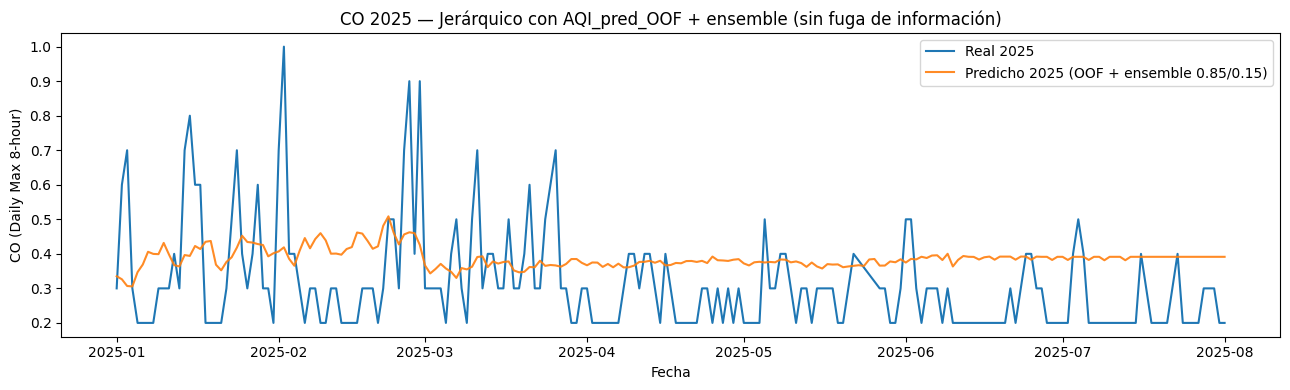

In [34]:
cmp = pd.DataFrame({"Date": df2025.index, "CO_real": df2025["CO"].values, "CO_pred": co_pred_25.values})
cmp = cmp.dropna().sort_values("Date").reset_index(drop=True)

# Métricas globales 2025
rmse_25 = float(np.sqrt(sk_mse(cmp["CO_real"], cmp["CO_pred"])))
mae_25  = float(sk_mae(cmp["CO_real"], cmp["CO_pred"]))
r2_25   = float(r2_score(cmp["CO_real"], cmp["CO_pred"]))
print(f"Comparación 2025 (ensemble 0.85/0.15): RMSE={rmse_25:.4f} | MAE={mae_25:.4f} | R²={r2_25:.4f}")

# ---- Tablas de comparación ----
# Errores
cmp["AbsError"]   = (cmp["CO_real"] - cmp["CO_pred"]).abs()
cmp["SignedErr"]  =  cmp["CO_pred"] - cmp["CO_real"]
# APE protegido por valores muy bajos (evita divisiones grandes por 0)
eps = 1e-6
cmp["APE_%"] = 100.0 * (cmp["AbsError"] / np.maximum(cmp["CO_real"].abs(), eps))

# Diario
daily_tbl = cmp.copy()

# Semanal (promedios y error medio)
weekly_tbl = (cmp
              .set_index("Date")
              .resample("W")
              .agg({"CO_real":"mean","CO_pred":"mean","AbsError":"mean","APE_%":"mean"})
              .reset_index())

# Mensual
monthly_tbl = (cmp
               .set_index("Date")
               .resample("M")
               .agg({"CO_real":"mean","CO_pred":"mean","AbsError":"mean","APE_%":"mean"})
               .reset_index())

# Mostrar las 5 primeras filas
print("\n== Comparación DIARIA 2025 ==")
display(daily_tbl.head(5))

print("\n== Comparación SEMANAL 2025 ==")
display(weekly_tbl.head(5))

print("\n== Comparación MENSUAL 2025 ==")
display(monthly_tbl.head(5))

# Guardar a CSV
daily_tbl.to_csv("CO_2025_comparacion_diaria.csv", index=False)
weekly_tbl.to_csv("CO_2025_comparacion_semanal.csv", index=False)
monthly_tbl.to_csv("CO_2025_comparacion_mensual.csv", index=False)
print("\nArchivos guardados:\n- CO_2025_comparacion_diaria.csv\n- CO_2025_comparacion_semanal.csv\n- CO_2025_comparacion_mensual.csv")

# ---- Gráfico 2025 ----
plt.figure(figsize=(13,4))
plt.plot(cmp["Date"], cmp["CO_real"], label="Real 2025")
plt.plot(cmp["Date"], cmp["CO_pred"], label="Predicho 2025 (OOF + ensemble 0.85/0.15)", alpha=0.9)
plt.title("CO 2025 — Jerárquico con AQI_pred_OOF + ensemble (sin fuga de información)")
plt.xlabel("Fecha"); plt.ylabel("CO (Daily Max 8-hour)")
plt.legend(); plt.tight_layout(); plt.show()
